Below, I present the code used to create Figure 1 in [Appendix C of "Considerations on transformative AI and explosive growth from a semiconductor-industry perspective"](https://muireall.space/pdf/considerations.pdf#page=17).

In [1]:
using CairoMakie
using LaTeXStrings
using QuadGK

### Equation 7.40: Phonon transmission coefficient T_trans

*Nanosystems* Section 7.3.5, "Scattering from alignment bands in bearings", describes calculations for drag between sliding surfaces with some analogy to dislocation physics. A key result quoted from a personal communication is a dimensionless phonon transmission coefficient T_trans. Friction as calculated in *Nanosystems* scales linearly with T_trans.

In [2]:
debye_integrand(k, T′) = k^3 / (exp(k/T′) - 1)
incidence_integrand_original(θ, k, d′) = sin(2θ) / ((d′ * k * cos(θ))^2 + 4) # 2θ
incidence_integrand(θ, k, d′) = sin(θ) / ((d′ * k * cos(θ))^2 + 4) # θ
incidence(k, d′, integrand=incidence_integrand) =
    quadgk(θ->integrand(θ, k, d′), 0, π/2)[1]

function T_trans(d′, T′, incidence_integrand=incidence_integrand)
    den, denerr = quadgk(k->(debye_integrand(k, T′)), 0, 1)
    num, numerr = quadgk(k->(debye_integrand(k, T′) * 
                             incidence(k, d′, incidence_integrand)), 0, 1)
    return (4/3) * num / den
end

T_trans (generic function with 2 methods)

Note that there are two versions of the incidence integrand. One uses sin(2θ) as written in the text, and the other uses sin(θ). The latter factor comes directly from integration in spherical coordinates, which follows from the prose's description of integrating 7.39 over a hemisphere, weighted by the Debye distribution. The equation as written implies an extra factor of 2cos(θ) with no justification and contradicts the comment on the next page that grazing-incidence phonons make a large contribution to T_trans.

### Equation 7.41: Engineering approximation for T_trans

In [3]:
function T_trans_approx(d_n, T′)
    z = 0.6*d_n^-1.7 * (1 + 0.075 * T′^-1.8)
    return z/(1 + 3z)
end

T_trans_approx (generic function with 1 method)

### Figure 7.6: T_trans vs d_n

In [4]:
T′s = [0.01, 0.03, 0.1, 0.3, 1, 10]
dnlog = 0.1:0.1:4

function dnlog_to_d′(dl)
    dn = 10^dl
    d′ = dn * (6*π^2)^(1/3)
    return d′
end

dnlog_to_d′ (generic function with 1 method)

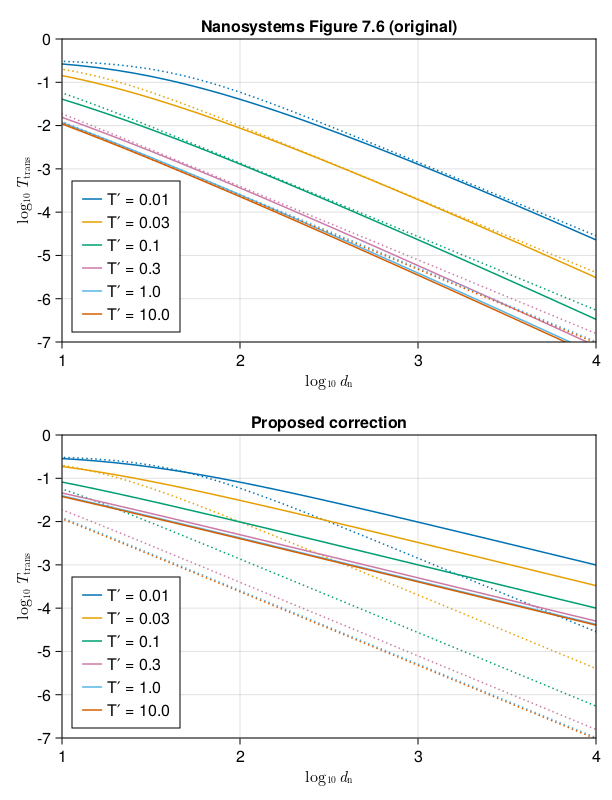

In [5]:
fig = Figure(resolution=(612,800))
ax = Axis(fig[1,1], xlabel=L"\log_{10}\,d_\mathrm{n}", ylabel=L"\log_{10}\,T_\mathrm{trans}",
    title="Nanosystems Figure 7.6 (original)")

for (i, T′) in pairs(T′s)
    lines!(ax, dnlog, log10.(T_trans.(dnlog_to_d′.(dnlog), T′, incidence_integrand_original)),
        color=Cycled(i), label="T′ = $(T′)")
    lines!(ax, dnlog, log10.(T_trans_approx.(10.0.^dnlog, T′)),
        color=Cycled(i), linestyle=:dot)
end
xlims!(1,4)
ylims!(-7,0)
axislegend(ax, position=:lb)

ax = Axis(fig[2,1], xlabel=L"\log_{10}\,d_\mathrm{n}", ylabel=L"\log_{10}\,T_\mathrm{trans}",
    title="Proposed correction")

for (i, T′) in pairs(T′s)
    lines!(ax, dnlog, log10.(T_trans.(dnlog_to_d′.(dnlog), T′)),
        color=Cycled(i), label="T′ = $(T′)")
    lines!(ax, dnlog, log10.(T_trans_approx.(10.0.^dnlog, T′)),
        color=Cycled(i), linestyle=:dot)
end
xlims!(1,4)
ylims!(-7,0)
axislegend(ax, position=:lb)

current_figure()

For the values of d_n ~ 100–1000 in exemplars in *Nanosystems*, the proposed correction is an increase by factor of 10 to 100, corresponding to the same increase in frictional forces.

Note that the proposed correction is unlikely to be physically relevant, as discussed in [the appendix](https://muireall.space/pdf/considerations.pdf#page=17). There are few reasons to think this is a good model of nanoscale friction and many reasons to suspect it is not. Either way, we should expect edge atoms to contribute orders of magnitude more friction than atoms in the inner contact areas considered here.